In [2]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
# from RF_Utils import *
from RF_GSCV import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load inhibition data 

In [11]:
# update Mar 27 moved directories 

In [3]:
split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/inhib'
# train_x_df = pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_trainX.csv")
# train_y_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_trainY.csv")
# test_x_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_testX.csv")
# test_y_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_testY.csv")
train_x_df = pd.read_csv(split_path+"/inhib_train_x_Morgan2UNDER.csv")
train_y_df= pd.read_csv(split_path+"/inhib_train_y_Morgan2UNDER.csv")
test_x_df= pd.read_csv(split_path+"/inhib_test_x_Morgan2UNDER.csv")
test_y_df= pd.read_csv(split_path+"/inhib_test_y_Morgan2UNDER.csv")

train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((223, 2048), (223,), (408, 2048), (408,))

In [4]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

# Undersample 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.814, precision: 0.233, recall: 0.750, specificity: 0.818


<Figure size 600x400 with 0 Axes>

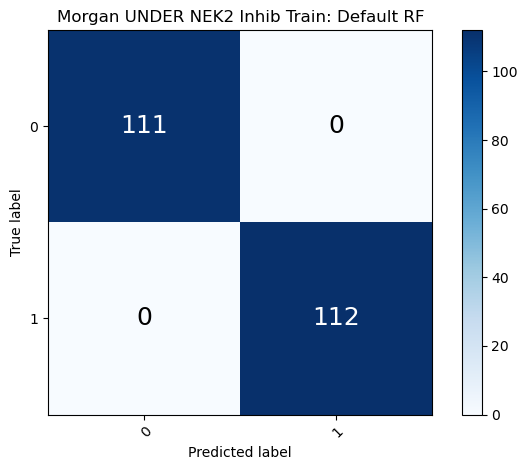

<Figure size 600x400 with 0 Axes>

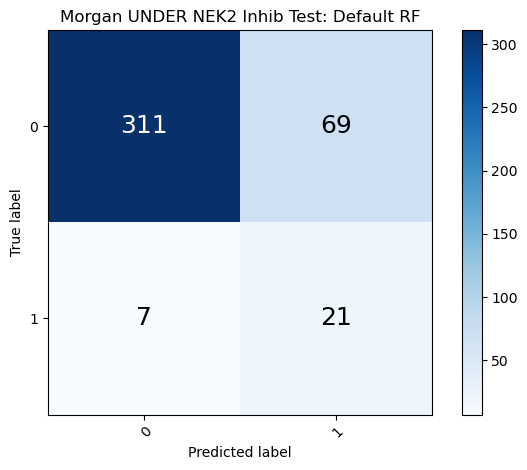

In [5]:
rf_basic100estUNDER = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {})
plot_confusion_matrix(train_y, rf_basic100estUNDER['train_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100estUNDER['test_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Test: Default RF')

In [6]:
save_file = 'atom_nek2inhibMorgan2UNDER_rf_basic_best.pkl'
# rf_basicbestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid,  2) #started Apr 27 1:36 am

TRAIN: accuracy: 0.982, precision: 1.000, recall: 0.964,  specificity: 1.000
TEST: accuracy: 0.816, precision: 0.236, recall: 0.750, specificity: 0.821


<Figure size 600x400 with 0 Axes>

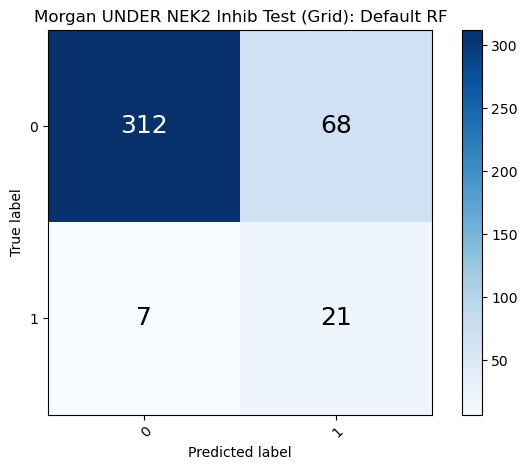

In [7]:
save_file = 'atom_nek2inhibMorgan2UNDER_rf_basic_best.pkl'
# with open(save_file, 'wb') as f:
#         pickle.dump(rf_basicbestUNDER['best_model'], f)
with open('../saved_models/'+save_file, 'rb') as f: 
    rf_basicbestUNDER = pickle.load(f) 
gridbasicresults = rf_results2(rf_basicbestUNDER, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridbasicresults['test_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Test (Grid): Default RF')



# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.811, precision: 0.231, recall: 0.750, specificity: 0.816


<Figure size 600x400 with 0 Axes>

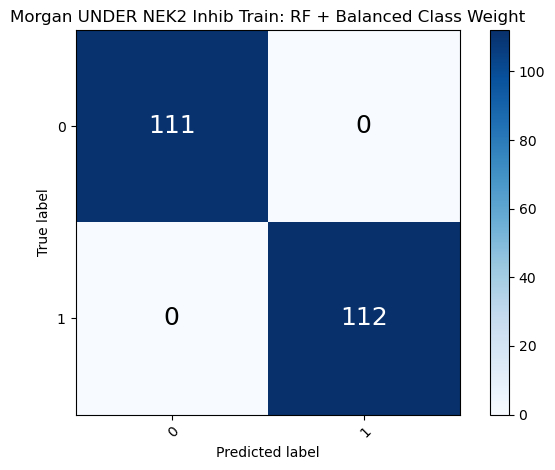

<Figure size 600x400 with 0 Axes>

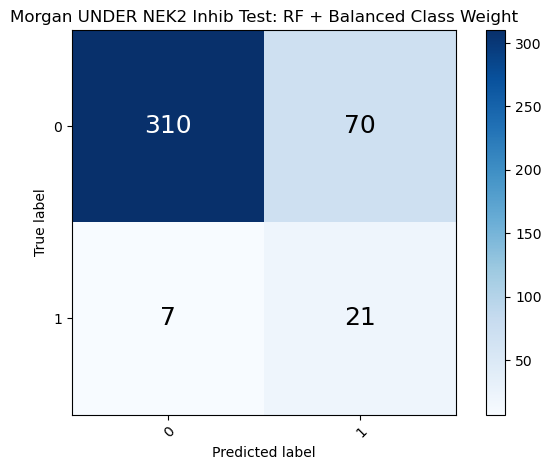

In [8]:
brf_model_BCW_UNDER = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {})
plot_confusion_matrix(train_y, brf_model_BCW_UNDER['train_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW_UNDER['test_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Test: RF + Balanced Class Weight')

In [9]:
save_file2 = 'atom_nek2inhibMorgan2UNDER_rf_basicBCW_best.pkl'
# rf_basicBCWbestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid, 2)



TRAIN: accuracy: 0.991, precision: 1.000, recall: 0.982,  specificity: 1.000
TEST: accuracy: 0.745, precision: 0.194, recall: 0.857, specificity: 0.737


<Figure size 600x400 with 0 Axes>

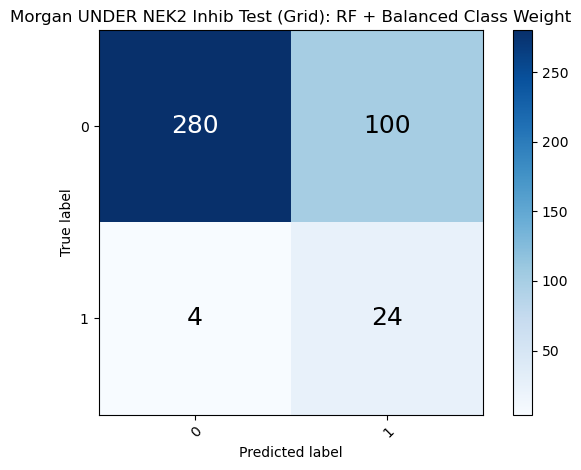

In [11]:
save_file2 = 'atom_nek2inhibMorgan2UNDER_rf_basicBCW_best.pkl'
# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbestUNDER, f)


with open('../saved_models/'+save_file2, 'rb') as f: 
    rf_basicBCWbestUNDER = pickle.load(f) 

gridrfbcwesults = rf_results2(rf_basicBCWbestUNDER, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, gridrfbcwesults['test_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Test (Grid): RF + Balanced Class Weight')



# Balanced Random Forest Classifier

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.814, precision: 0.233, recall: 0.750, specificity: 0.818


<Figure size 600x400 with 0 Axes>

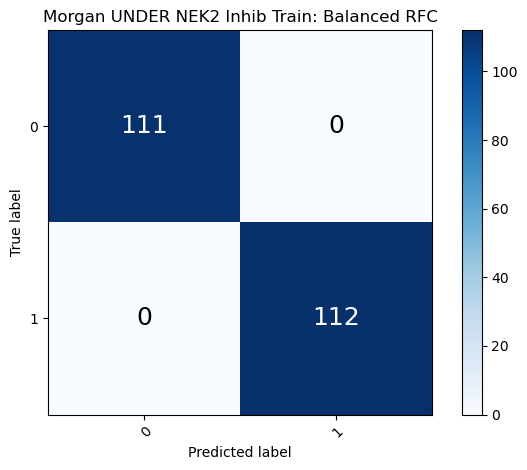

<Figure size 600x400 with 0 Axes>

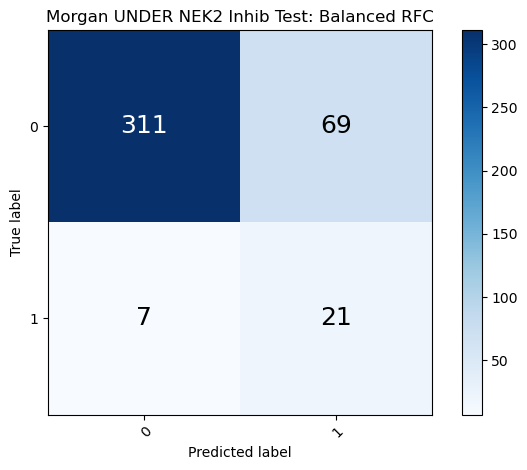

In [12]:
brf_modelUNDER = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {})
plot_confusion_matrix(train_y, brf_modelUNDER['train_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_modelUNDER['test_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Test: Balanced RFC')

In [13]:
save_file3 = 'atom_nek2inhibMorgan2UNDER_BRFC_best.pkl'
# brfc_bestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'balanced Rf', {}, param_grid, 2)
# started Apr 28 2:52 am 


TRAIN: accuracy: 0.991, precision: 1.000, recall: 0.982,  specificity: 1.000
TEST: accuracy: 0.748, precision: 0.200, recall: 0.893, specificity: 0.737


<Figure size 600x400 with 0 Axes>

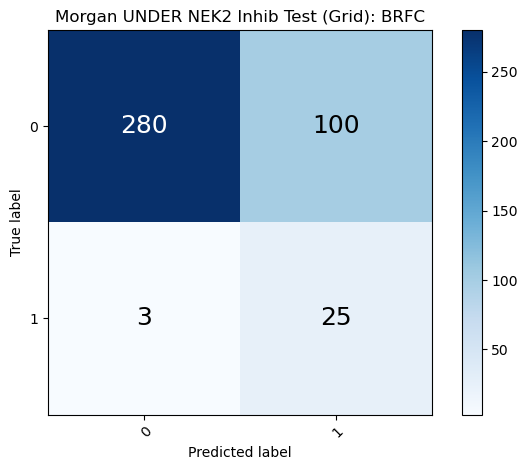

In [14]:
save_file3 = 'atom_nek2inhibMorgan2UNDER_BRFC_best.pkl'
# with open(save_file3, 'wb') as f:
#         pickle.dump(brfc_bestUNDER, f)
with open('../saved_models/'+save_file3, 'rb') as f: 
    brfc_bestUNDER = pickle.load(f) 
results3 = rf_results2(brfc_bestUNDER['best_model'], train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, results3['test_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Test (Grid): BRFC')



# Try BRFC with balanced class weight & bootstrap

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.904, precision: 0.396, recall: 0.750, specificity: 0.916


<Figure size 600x400 with 0 Axes>

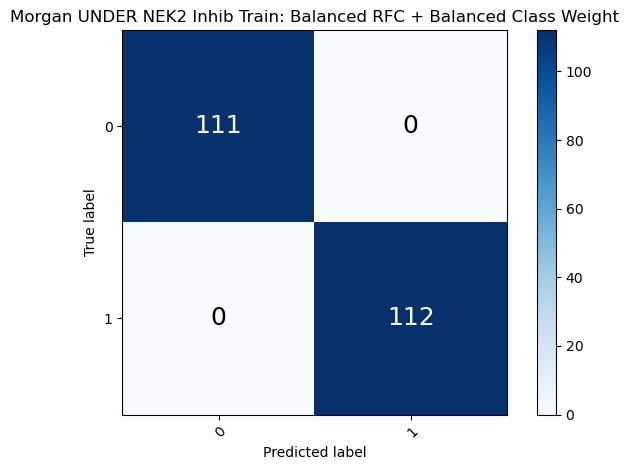

<Figure size 600x400 with 0 Axes>

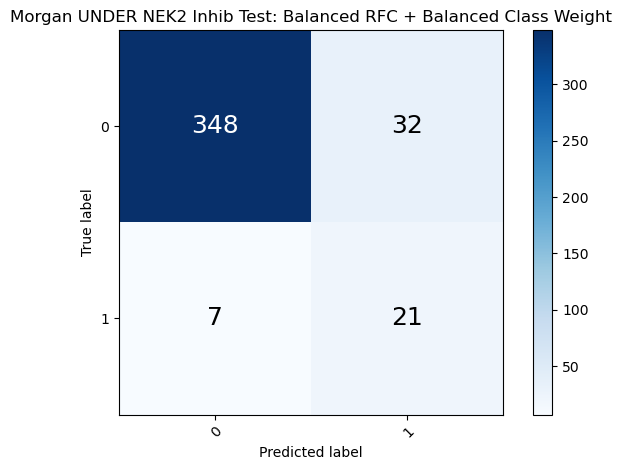

In [15]:
brf_modelCWB_UNDER = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True})
plot_confusion_matrix(train_y, brf_modelCWB_UNDER['train_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Train: Balanced RFC + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB_UNDER['test_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Test: Balanced RFC + Balanced Class Weight')

In [16]:
save_file4 = 'atom_nek2inhibMorgan2UNDER_BRFC_BCW_best.pkl'
# brfc_bcw_bestUNDER = find_best_models(train_x, train_y, test_x, test_y, 'balanced Rf', {'class_weight':'balanced', 'bootstrap':True}, param_grid, 2)
# started Apr 28 3:13 am


TRAIN: accuracy: 0.978, precision: 1.000, recall: 0.955,  specificity: 1.000
TEST: accuracy: 0.816, precision: 0.230, recall: 0.714, specificity: 0.824


<Figure size 600x400 with 0 Axes>

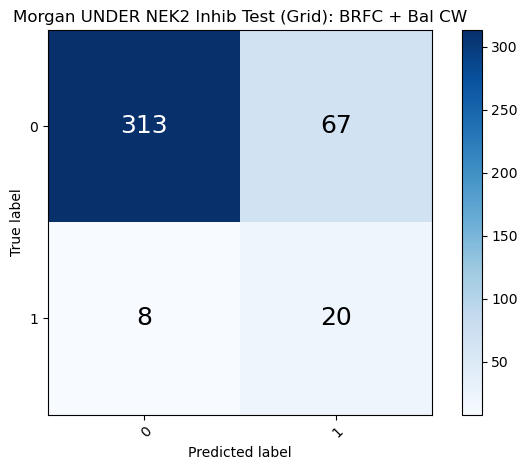

In [18]:
save_file4 = 'atom_nek2inhibMorgan2UNDER_BRFC_BCW_best.pkl'
# with open(save_file4, 'wb') as f:
#         pickle.dump(brfc_bcw_bestUNDER, f)
with open('../saved_models/'+save_file4, 'rb') as f: 
    brfc_bcw_best = pickle.load(f) 
results4 = rf_results2(brfc_bcw_best['best_model'], train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, results4['test_pred'], ['0','1'], title='Morgan UNDER NEK2 Inhib Test (Grid): BRFC + Bal CW')



In [49]:
nek2inhib_UNDERmodels = {'default_RF':rf_basicbestUNDER, 'rf_bcw':rf_basicBCWbestUNDER,
                              'BRFC':brfc_bestUNDER['best_model'], 'BRFC_bcw':brfc_bcw_best['best_model']}

with open('nek2inhib_MorganUNDERgridmodels.pkl', 'wb') as f:
    pickle.dump(nek2inhib_UNDERmodels, f)


In [50]:
nek2inhib_UNDERmodels

{'default_RF': RandomForestClassifier(bootstrap=False, max_depth=100, max_features=None,
                        min_samples_leaf=2, n_estimators=1050),
 'rf_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced',
                        criterion='entropy', max_depth=200, max_features=None,
                        min_samples_leaf=2),
 'BRFC': RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=200,
                        max_features=None, min_samples_leaf=2,
                        n_estimators=1050),
 'BRFC_bcw': RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=20,
                        max_features=None, min_samples_leaf=2,
                        n_estimators=1050)}

In [52]:
grid_models = [rf_basicbestUNDER, rf_basicBCWbestUNDER,
                brfc_bestUNDER['best_model'], brfc_bcw_best['best_model']]
model_dictionaries = []
for i, model in enumerate(grid_models): 
    train_results = save_rf_results(model, train_x, train_y)
    test_results  = save_rf_results(model, test_x, test_y) 
    model_dict = {'model':model, 'train_results':train_results, 'test_results':test_results}
    model_dictionaries.append(model_dict) 

with open('nek2_inhib_MorganUNDER_results.pkl', 'wb') as f:
    pickle.dump(model_dictionaries, f)

In [53]:
with open('nek2_inhib_MorganUNDER_results.pkl', 'rb') as f: 
    results1= pickle.load(f)
recalls = [] 
for m, model in enumerate(results1): 
    recalls.append(model['test_results']['recall'])
# recalls

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 49.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 50.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

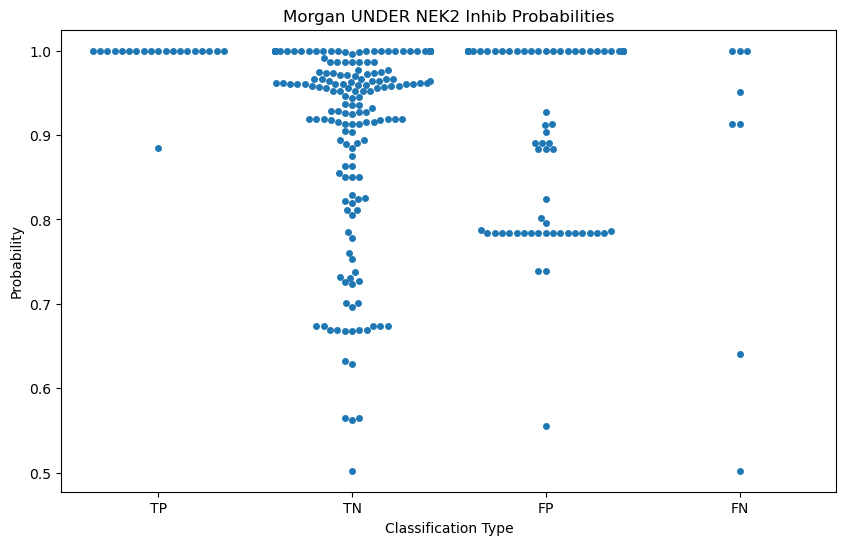

In [56]:
swarm_prob(brfc_bcw_best['best_model'], test_x, test_y, 'Morgan UNDER NEK2 Inhib Probabilities')